<center><img src="https://github.com/hse-ds/iad-applied-ds/blob/master/2021/hw/hw1/img/logo_hse.png?raw=1" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 4: Прогнозирование временных рядов</center></h2>

# Введение

В этом задании Вам предстоит разобраться с основами анализа и прогнозирования временных рядов. 


![image](https://imgs.xkcd.com/comics/extrapolating.png)

In [102]:
!pip install orbit-ml
!pip install prophet
!pip install sktime[all_extras]

  Using cached https://files.pythonhosted.org/packages/23/3d/db9a6b3c83c9511301152dbb64a029c3a4313c86eaef12c237b13ecf91d6/matplotlib-3.3.4-cp37-cp37m-manylinux1_x86_64.whl
ERROR: prophet 1.0.1 has requirement cmdstanpy==0.9.68, but you'll have cmdstanpy 0.9.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3


  Using cached https://files.pythonhosted.org/packages/08/b9/b4f0938b38dbe775c4def707f525ab816b9d0215ecd8ab2d76780f4514f8/cmdstanpy-0.9.68-py3-none-any.whl
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
  Using cached https://files.pythonhosted.org/packages/e3/e2/204c9c6beaf9e05ad28bd589c154afff35dffa6166d76841d3c0dec6c1e3/cmdstanpy-0.9.5-py3-none-any.whl
ERROR: prophet 1.0.1 has requirement cmdstanpy==0.9.68, but you'll have cmdstanpy 0.9.5 which is incompatible.
  Found existing installation: cmdstanpy 0.9.68
    Uninstalling cmdstanpy-0.9.68:
      Successfully uninstalled cmdstanpy-0.9.68


In [304]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import plotly.express as px 
import plotly.graph_objects as go


## Задание 1 (2 балла). Поиск и предобработка данных.

В этом задании Вам необходимо _самостоятельно_ найти два временных ряда: один должен обладать месячной частотой, а второй — дневной.

Мы советуем поискать соответствующие временные ряды на платформе [kaggle](https://www.kaggle.com/datasets) или же взять один из [популярных](https://medium.com/analytics-vidhya/10-time-series-datasets-for-practice-d14fec9f21bc) временных рядов для анализа. 

**Не рекоммендуется** использовать в качестве временных рядов цены финансовых инструментов в силу плохой предсказуемости изменения цен. **Запрещается** использовать готовые наборы данных из библиотек для анализа временных рядов, например, `from orbit.utils.dataset import load_iclaims`.

![bitcoin](https://avatars.mds.yandex.net/get-zen_doc/3417386/pub_6017dd4b8d30cb1780864ae0_6017f4aa8d30cb1780bf66ce/scale_1200)




В качестве отчета по заданию:

* Опишите источники временных рядов (ссылки на страницы скачивания). В случае, если данные требовали дополнительной обработки, приведите код этой обработки, загрузите данные в личное облачное хранилище и приведите ссылку на скачивание. Процесс получения временных рядов должен быть **четко** расписан и полностью **воспроизводиться**. 

* Приведите код считывания временных рядов из файлов и разделения на train/test. Соотношение размеров train/test на Ваше усмотрение, но мы советуем Вам выбрать 80% на 20%, если в test остаётся хотя бы пара лет наблюдений.



## Описание данных:

__Месячный сет__: https://www.kaggle.com/andreazzini/international-airline-passengers

Данные взяты с кэггла и представляют собой ежемесячное число пассажиров с 1949 по 1960 год



__Дневной сет__: https://www.kaggle.com/bobnau/daily-website-visitors

Данные за пять лет, из которых я беру колонку с количеством загрузок страницы, более подробное описание можно посмотреть на кэггле

In [269]:
# считаем файлы
ts2 = pd.read_csv('https://raw.githubusercontent.com/aromana33/hw7_dl_2021/main/daily-website-visitors.csv', index_col=0)
ts2 = ts2[['Date', 'Page.Loads']] 
ts2 = ts2.rename(columns={'Page.Loads': 'value'})
ts2['Date'] = pd.to_datetime(ts2['Date'])
ts2 = ts2.set_index('Date')
ts2['value'] = ts2['value'].str.split(',').str.join('').astype(int)

In [384]:
ts1 = pd.read_csv('https://raw.githubusercontent.com/aromana33/hw7_dl_2021/main/international-airline-passengers.csv', index_col=0)

In [386]:
ts1 = ts1[:-1]

In [387]:
ts1 = ts1.rename(columns={'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60': 'value'})
ts1.index = pd.to_datetime(ts1.index, format='%Y-%m')
ts1.index = pd.PeriodIndex(ts1.index, freq='M')


In [270]:
ts2.index = pd.PeriodIndex(ts2.index, freq='D')

In [390]:
# сделаем разбиение на train/test
from sktime.forecasting.model_selection import temporal_train_test_split
day_train, day_test = temporal_train_test_split(ts2['value'], test_size=0.2)
month_train, month_test = temporal_train_test_split(ts1['value'], test_size=0.2)

In [391]:
# Сделаем сразу на будущее в другом виде
month_train1 = pd.DataFrame(month_train.reset_index()['value'].tolist(), ts1.index[:len(month_train)].tolist(), columns=['value']).reset_index() 
month_test1 = pd.DataFrame(month_test.reset_index()['value'].tolist(), ts1.index[len(month_train):].tolist(), columns=['value']).reset_index() 

day_train1 = pd.DataFrame(day_train.reset_index()['value'].tolist(), ts2.index[:len(day_train)].tolist(), columns=['value']).reset_index() 
day_test1 = pd.DataFrame(day_test.reset_index()['value'].tolist(), ts2.index[len(day_train):].tolist(), columns=['value']).reset_index() 

## Задание 2. Анализ временных рядов (1 балла).

* Отрисуйте временные ряды и визуально сделайте различимым разбиение на выборки — либо вертикальной чертой, либо разными цветами.

* Постройте графики автокорреляционных функций для выбранных временных рядов. Прокомментируйте их: являются ли временные ряды сезонными? Видна ли на графиках длина сезонной составляющей ряда?

* В случае присутствия сезонности, разбейте временной ряд на повторяющиеся фрагменты и нарисуйте их наложенными для иллюстрации этой сезонности.

In [39]:
# !pip install matplotlib==3.1.3 # если вдруг не запускается график

### Отрисуем временные ряды, разделив их цветом
---

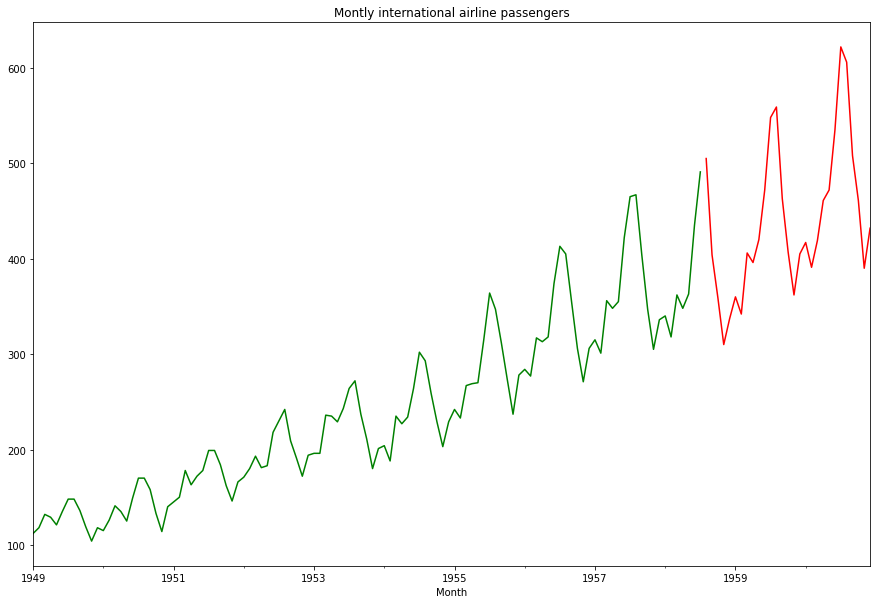

In [392]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
month_train.plot(ax=ax, label='train', color='g', title='Montly international airline passengers')
month_test.plot(ax=ax, label='test', color='r');


Видна довольно четко ежегодная сезонность и возрастающий тренд в данных, что логично для данных о пассажирах самолета)))

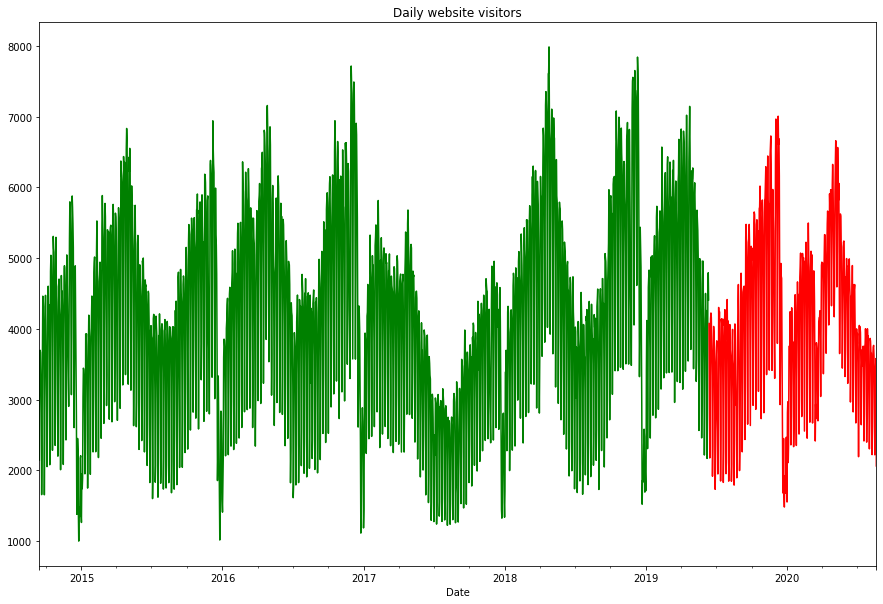

In [193]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
day_train.plot(ax=ax, label='train', color='g', title='Daily website visitors')
day_test.plot(ax=ax, label='test', color='r');

Заметна скорее ежегодовая сезонность, хотя в таких данных вообще непонятно как они работают.

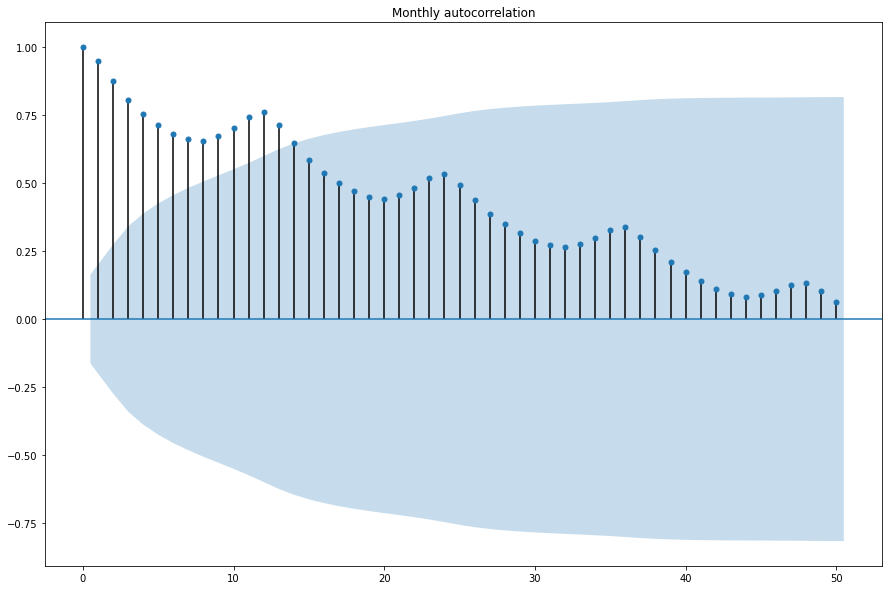

In [393]:
# посчитайте и нарисуйте график автокорреляционной функции
# hint, используйте для этого np.correlate(..., mode='full')

# воспользуемся готовым методом для отрисовки автокорреляционной функции6 спасибо Борису Борисовичу
from statsmodels.graphics.tsaplots import plot_acf

with plt.rc_context():
    plt.rc("figure", figsize=(15,10))
    plot_acf(ts1['value'], lags=50, title='Monthly autocorrelation');

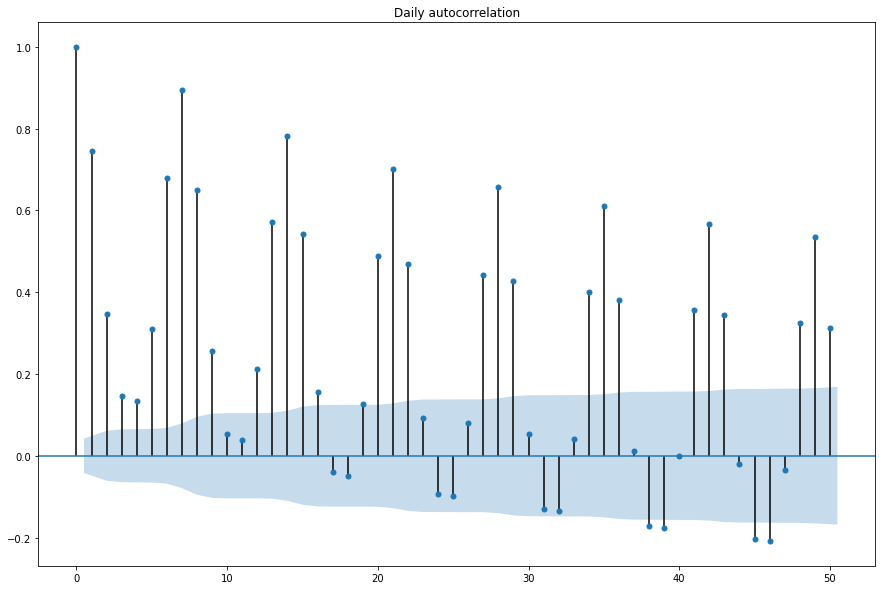

In [195]:
with plt.rc_context():
    plt.rc("figure", figsize=(15,10))
    plot_acf(ts2['value'], lags=50, title='Daily autocorrelation');

In [196]:
# разбейте временной ряд на повторяющиеся участки по длине сезонной составляющей и нарисуйте их наложенными

In [397]:
ts_g = pd.read_csv('https://raw.githubusercontent.com/aromana33/hw7_dl_2021/main/international-airline-passengers.csv', index_col=0)
ts_g = ts_g[:-1]
ts_g.index = pd.to_datetime(ts_g.index)

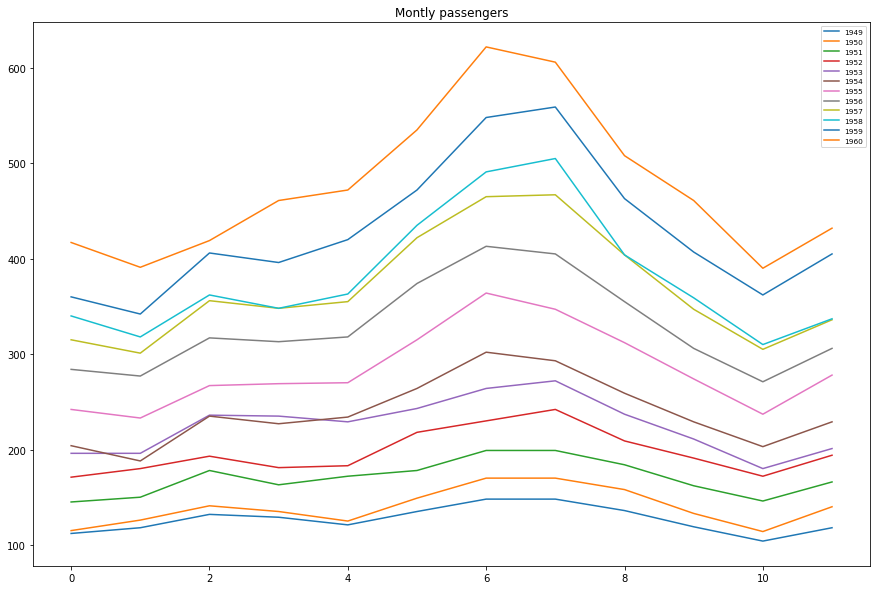

In [400]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
for year in np.arange(1949, 1961):
  arr = ts_g[ts_g.index.year == year].to_numpy()
  plt.plot(arr, label=str(year))
  plt.title('Montly passengers')
  plt.legend(loc='upper right', fontsize=7.4);

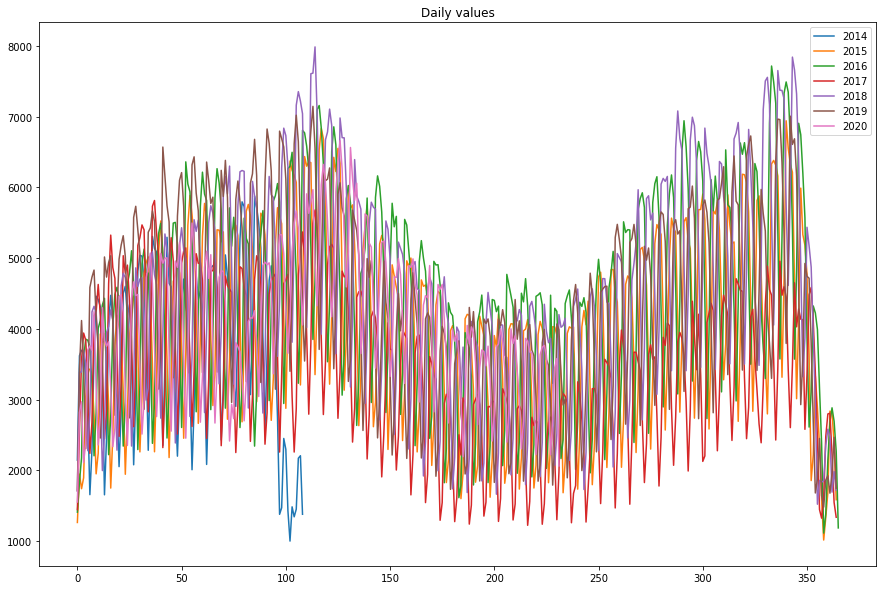

In [112]:
fig, ax = plt.subplots(1,1, figsize=(15, 10))
for year in np.arange(2014, 2021):
  arr = ts2[ts2.index.year == year].to_numpy()
  plt.plot(arr, label=str(year))
  plt.title('Daily values')
  plt.legend();

### Комментарии:

Явно видна сезонность, особенно в ежедневнх данных, в обоих случаях сехонность скорее годовая, хотя в ежедневных можно, пожалуй заметить и месячную компоненту сезонности

## Задание 3. Предсказание месячного временного ряда (4.5 балла).

В этом задании Вам предстоит попробовать предсказать месячный временной несколькими готовыми моделями со скользящим или растущим окном и выбрать среди них наилучшую.

В качестве метрики сравнения используйте MAE между истинными и предсказанными значениями ряда на тестовом отрезке.


---
Сразу скажу, что почти все модели взяты из документации, так что там без особых изяществ)))

### NaiveForecaster из sktime (0.5 балл).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [113]:
from sktime.forecasting.naive import NaiveForecaster
from sklearn.metrics import mean_absolute_error as MAE
from sktime.forecasting.base import ForecastingHorizon


## 1 наивный способ

$\hat{y}_{t+1} = y_{t}$

In [401]:
fh = ForecastingHorizon(month_test.index, is_relative=False)

In [402]:
forecaster = NaiveForecaster(strategy="last", 
                             sp=1)
forecaster.fit(month_train)
preds = forecaster.predict(fh)

In [403]:
print(f'MAE Naive LAST={MAE(preds, month_test)}')

MAE Naive LAST=81.44827586206897


Пока что это выглядит очень так себе хаха

## 2 наивный способ

$\hat{y}_{t+1} = y_{t-seasonality+1}$

In [404]:
forecaster = NaiveForecaster(strategy="last", 
                             sp=12)
forecaster.fit(month_train)
preds = forecaster.predict(fh)

In [405]:
print(f'MAE Naive LAST season={MAE(preds, month_test)}')

MAE Naive LAST season=64.75862068965517


Окей...

### ARIMA/AutoArima (1 балл).

Обучите из библиотеки `sktime` модели:

* SARIMA(1, 1, 1)(1, 0, 0)[12] (`ARIMA` в `sktime`)
* Алгоритм Хиндмана-Хандакара подбора SARIMA (`AutoARIMA` в `sktime`)

### SARIMA

In [406]:
from sktime.forecasting.arima import ARIMA, AutoARIMA

forecaster = ARIMA(order=(1, 1, 1), 
                   seasonal_order=(1, 0, 0, 12), 
                   suppress_warnings=True)
forecaster.fit(month_train)
preds = forecaster.predict(fh)
print(f'MAE SARIMA={MAE(preds, month_test)}')

MAE SARIMA=23.501721560283958


### AutoARIMA

In [407]:
forecaster = AutoARIMA(sp=12, 
                       suppress_warnings=True)
forecaster.fit(month_train) 
preds = forecaster.predict(fh)
print(f'MAE AutoARIMA={MAE(preds, month_test)}')

MAE AutoARIMA=28.54740879225249


### LGT/DLT (1 балл).

Обучите из библиотеки `orbit` модели LGT и DLT

In [408]:
from orbit.models.lgt import LGTFull
from orbit.models.dlt import DLTFull


# ваш код обучения моделей здесь

In [409]:
# до этого требовалось, чтобы данные были в формате периода, теперь вернем в таймстэмп
month_train1['index'] = month_train1['index'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d %H:%M:%S.000')
month_test1['index'] = month_test1['index'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d %H:%M:%S.000')

### LGT
---

In [410]:
lgt = LGTFull(
    response_col='value',
    date_col='index',
    seasonality=12,
    seed=8888
)
lgt.fit(month_train1)
preds_lgt = lgt.predict(month_test1)
preds_lgt.tail()

,index,prediction_5,prediction,prediction_95
24,1960-08-01 00:00:00.000,491.734052,539.449834,607.069099
25,1960-09-01 00:00:00.000,410.893083,474.833225,549.059635
26,1960-10-01 00:00:00.000,360.474892,420.023217,478.001026
27,1960-11-01 00:00:00.000,319.842027,384.409554,446.073280
28,1960-12-01 00:00:00.000,364.979908,410.197804,474.642449


In [411]:
print('MAE on test LGT =', MAE(preds_lgt['prediction'], month_test))

MAE on test LGT = 21.50804256689877


А вот и лучшая модель подъехала:) По ней дальше будет нарисован график с предсказанием и доверительным интервалом!

### DLT
---

In [412]:
DLT = DLTFull(
    response_col='value',
    date_col='index',
    seasonality=12
)
DLT.fit(month_train1)
preds_dlt = DLT.predict(month_test1)
preds_dlt.tail()

,index,prediction_5,prediction,prediction_95
24,1960-08-01 00:00:00.000,379.827782,470.768733,1014.530468
25,1960-09-01 00:00:00.000,312.519915,398.661109,986.920286
26,1960-10-01 00:00:00.000,261.613193,344.878985,952.122218
27,1960-11-01 00:00:00.000,224.962155,309.455192,959.090505
28,1960-12-01 00:00:00.000,265.652993,336.384739,1049.836310


In [413]:
print('MAE on test DLT =', MAE(preds_dlt['prediction'], month_test))

MAE on test DLT = 58.37870488736975


### ETS (2 балла).

Обучите из библиотеки `sklearn` модели:

* ETS(AAA) (`ExponentialSmoothing` в `sktime`)
* ETS с автоматическим выбором по AIC (`AutoETS` в `sktime`)

In [414]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS

# ваш код обучения моделей здесь

### ETS(AAA)
---

In [415]:
ETS_AAA = ExponentialSmoothing(trend='add', 
                               seasonal='additive', 
                               sp=12,
                               use_boxcox=False)
ETS_AAA.fit(month_train)
preds = ETS_AAA.predict(fh)

In [416]:
print('MAE on test ETS AAA =', MAE(preds, month_test))

MAE on test ETS AAA = 31.791085707772247


### ETS & AIC
---

In [417]:
ETS_AIC = AutoETS(auto=True,
    #trend='add', 
    #seasonal='additive', 
    sp=12)
ETS_AIC.fit(month_train)
preds = ETS_AIC.predict(fh)

In [418]:
print('MAE on test ETS AIC =', MAE(preds, month_test))

MAE on test ETS AIC = 25.14432747140645


Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения. В `sktime` `ETS` модель пока ещё не выдаёт доверительные интервалы, но при желании до них можно дотянуться :)

In [419]:
# нарисуйте пресказания
fig = go.Figure([
    go.Scatter(
        x=preds_lgt['index'], 
        y=month_test.tolist(),
        line=dict(color='blue', width=2),
        mode='lines',
        name='Истинные значения'
    )
])
fig.add_trace(go.Scatter(
        x=preds_lgt['index'], 
        y=preds_lgt['prediction'],
        line=dict(color='green', width=2),
        mode='lines',
        name='Прогноз'
    ))
fig.add_trace(
    go.Scatter(
        x=preds_lgt['index'],
        y=preds_lgt['prediction_5'],
        line_color='rgba(141, 203, 143, 0.3)',
        mode='lines',
        fill=None,
        showlegend=False
    ))
fig.add_trace(
    go.Scatter(
        x=preds_lgt['index'], # x, then x reversed
        y=preds_lgt['prediction_95'], # upper, then lower reversed
        fill='tonexty',
        line_color='rgba(141, 203, 143, 0.3)',
        #line_color='rgba(0, 0, 0, 0)',
        name='Доверительный интервал'
    ))



fig.update_layout(
    xaxis_title="Дата",
    yaxis_title="Значение",
    legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01),
          title='Доверительный интервал для прогноза для ежемесячны данных')
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)',
                   'paper_bgcolor': 'rgba(0, 0, 0, 0)',})
fig.show()


## Задание 4. Предсказание дневного временного ряда (2.5 балла).

В этом задании Вам предстоит попробовать предсказать выбранный Вами дневной временной ряд.

Аналогично, в качестве метрики используем MAE.



### NaiveForecaster из sktime (0.5 балла).

Посчитайте предсказания следующими двумя наивными способами:

* $\hat{y}_{t+1} = y_{t}$
* $\hat{y}_{t+1} = y_{t-seasonality+1}$

In [278]:
from sktime.forecasting.naive import NaiveForecaster

# 1

fh = ForecastingHorizon(day_test.index, is_relative=False)
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(day_train)
preds = forecaster.predict(fh)
print(f'MAE Naive LAST daily={MAE(preds, day_test)}')

#2

forecaster = NaiveForecaster(strategy="last", 
                             sp=365)
forecaster.fit(day_train)
preds = forecaster.predict(fh)

print(f'MAE Naive LAST season daily={MAE(preds, day_test)}')

MAE Naive LAST daily=1012.6013824884793
MAE Naive LAST season daily=996.557603686636


Мы еще на прошлых данных поняли, что эти модели себя очень так себе показывают))

### KTR из orbit (1 балл).



In [286]:
# до этого требовалось, чтобы данные были в формате периода6 теперь вернем в таймстэмп
day_train1['index'] = day_train1['index'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d %H:%M:%S.000')
day_test1['index'] = day_test1['index'].dt.to_timestamp('s').dt.strftime('%Y-%m-%d %H:%M:%S.000')

In [287]:
from orbit.models.ktrlite import KTRLiteMAP

# ваш код обучения моделей здесь

from orbit.estimators.stan_estimator import StanEstimatorMCMC, StanEstimatorMAP
ktrlite = KTRLiteMAP(
    response_col='value',
    date_col='index',
    seasonality=[7, 14, 365],
    seasonality_fs_order=[2, 2, 5],
    estimator_type=StanEstimatorMAP,
)
ktrlite.fit(day_train1)
predicted_df = ktrlite.predict(day_test1, decompose=True)
predicted_df.tail()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_54eae5ecf2d426f33baa7b746b329122 NOW.


,index,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_7_5,seasonality_7,seasonality_7_95,seasonality_14_5,seasonality_14,seasonality_14_95,seasonality_365_5,seasonality_365,seasonality_365_95
429,2020-08-15 00:00:00.000,1548.337665,3870.537586,6227.642914,3868.771885,3870.453746,3872.056295,-0.534219,-0.534219,-0.534219,-0.180337,-0.180337,-0.180337,0.785047,0.785047,0.785047
430,2020-08-16 00:00:00.000,1511.441716,3871.254883,6275.440636,3868.771885,3870.453746,3872.056295,0.070132,0.070132,0.070132,-0.100981,-0.100981,-0.100981,0.818639,0.818639,0.818639
431,2020-08-17 00:00:00.000,1553.759537,3871.951974,6231.384835,3868.771885,3870.453746,3872.056295,0.442226,0.442226,0.442226,0.192581,0.192581,0.192581,0.850073,0.850073,0.850073
432,2020-08-18 00:00:00.000,1545.899738,3871.537787,6209.209910,3868.771885,3870.453746,3872.056295,-0.245248,-0.245248,-0.245248,0.436727,0.436727,0.436727,0.879214,0.879214,0.879214
433,2020-08-19 00:00:00.000,1559.470216,3871.513883,6156.278896,3868.771885,3870.453746,3872.056295,-0.245248,-0.245248,-0.245248,0.386110,0.386110,0.386110,0.905927,0.905927,0.905927


In [293]:
# посчитайте метрики на test

print(f"KTR daily={MAE(predicted_df['prediction'], day_test1.value)}")

KTR daily=956.4947611959109


Незначительное улучшение

### Phophet (1 балл).



In [297]:
from prophet import Prophet

# ваш код обучения моделей здесь
day_train1 = day_train1.rename(columns={'index':'ds', 'value':'y'})
day_test1 = day_test1.rename(columns={'index':'ds', 'value':'y'})

In [299]:
Prophet = Prophet()
Prophet.fit(day_train1)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [301]:
preds = Prophet.predict(day_test1.drop('y', axis=1))
preds.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
429,2020-08-15,4155.143940,40.941989,3005.148153,2868.516436,5517.011726,-2617.961589,-2617.961589,-2617.961589,-1681.727601,-1681.727601,-1681.727601,-936.233988,-936.233988,-936.233988,0.0,0.0,0.0,1537.182351
430,2020-08-16,4154.530741,786.314310,3813.503218,2860.668012,5522.133685,-1845.900960,-1845.900960,-1845.900960,-912.144378,-912.144378,-912.144378,-933.756582,-933.756582,-933.756582,0.0,0.0,0.0,2308.629781
431,2020-08-17,4153.917543,2406.900168,5480.546363,2852.819588,5526.936123,-167.474618,-167.474618,-167.474618,764.994365,764.994365,764.994365,-932.468983,-932.468983,-932.468983,0.0,0.0,0.0,3986.442925
432,2020-08-18,4153.304344,2601.332681,5566.738218,2844.971164,5531.738561,-51.506915,-51.506915,-51.506915,880.870486,880.870486,880.870486,-932.377401,-932.377401,-932.377401,0.0,0.0,0.0,4101.797429
433,2020-08-19,4152.691145,2541.476035,5484.330813,2837.122740,5536.540998,-118.419118,-118.419118,-118.419118,815.002307,815.002307,815.002307,-933.421425,-933.421425,-933.421425,0.0,0.0,0.0,4034.272027


In [303]:
# посчитайте метрики на test
print(f"MAE Prophet daily={MAE(preds['yhat'], day_test1.y)}")

MAE Prophet daily=461.7117988683474


Профет и стал лучшей моделью, так что рисуем для него картинку!

Нарисуйте для наилучшей модели предсказания с доверительным интервалом (если модель выдает его) и наложите их на истинные значения.

In [342]:
# нарисуйте пресказания
fig = go.Figure([
    go.Scatter(
        x=day_test1.ds, 
        y=day_test1.y,
        line=dict(color='blue', width=2),
        mode='lines',
        name='Истинные значения'
    )
])
fig.add_trace(go.Scatter(
        x=day_test1.ds, 
        y=preds['yhat'],
        line=dict(color='green', width=2),
        mode='lines',
        name='Прогноз'
    ))
fig.add_trace(
    go.Scatter(
        x=day_test1.ds,
        y=preds['yhat_lower'],
        line_color='rgba(141, 203, 143, 0.3)',
        mode='lines',
        fill=None,
        showlegend=False
    ))
fig.add_trace(
    go.Scatter(
        x=day_test1.ds, # x, then x reversed
        y=preds['yhat_upper'], # upper, then lower reversed
        fill='tonexty',
        line_color='rgba(141, 203, 143, 0.3)',
        #line_color='rgba(0, 0, 0, 0)',
        name='Доверительный интервал'
    ))



fig.update_layout(
    xaxis_title="Дата",
    yaxis_title="Значение",
    legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01),
          title='Доверительный интервал для прогноза Prophet для ежедневных данных')
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)',
                   'paper_bgcolor': 'rgba(0, 0, 0, 0)',})
fig.show()



## Бонус. Напишите свою модель на STAN (3 балла).

Разработайте и испытай свою модель для месячного ряда в STAN.

Сравните качество прогнозов с наивной сезонной на тестовой выборке с помощью MAE. 



In [ ]:
# ваш код модели на STAN и её обучения моделей здесь

In [373]:
!pip install arviz
!pip install pystan

In [374]:
import pystan # probabilistic programming language
import arviz as az # visualizations for bayesian approach

In [420]:
model_code = """
data {
  int<lower=0> n;         // number of observations
  vector[n] y;            // time series data
  vector[n] x;            // predictor
}
parameters {
  // equation parameters
  real<lower=0, upper=1> alpha;   // alpha
  real<lower=0, upper=1> beta;    // beta
  real<lower=0, upper=1> gamma;    // gamma
  real<lower=0, upper=1> theta;    // theta
  real k;                          // k
  real<lower=0> sigma;             // sigma

  // initial values
  real linit;        // linit
  real binit;        // binit
  vector[12] sinit;  // sinit
}
transformed parameters {
  vector[n+1] l;  // l
  vector[n+1] b;  // b
  vector[n+12] s;  // s
  vector[n] r;     // r
  vector[n] yhat;  // E(y_t | F_{t-1})

  // initial observations
  l[1] = linit;      // l
  b[1]=  binit;      // b
  for (t in 1:12) { // s
    s[t] = sinit[t];
  }          

  // update equations
  for (t in 1:n) {
    
    int tp; 
    int ts;

    tp = t + 1;
    ts = t + 12;

    r[t] = k * x[t];
    b[tp] = (1 - beta) * theta * b[tp-1] + beta * (y[t] - l[tp-1] - s[ts-12] - r[t]);
    s[ts] = s[ts-12] + gamma * (y[t] - l[tp-1] - theta * b[tp-1] - s[ts-12] - r[t]);
    l[tp] = (1 - alpha) * (l[tp-1] + r[t] + theta * b[tp-1])  + alpha * (y[t] - s[ts-12]);
    yhat[t] = l[tp-1] + theta * b[tp-1] + s[ts-12] + r[t];
  }
}

model {
  // prior for e-parameters
  alpha ~ uniform(0, 1);
  beta ~ uniform(0, 1);
  gamma ~ uniform(0, 1);
  theta ~ uniform(0, 1);
  sigma ~ normal(0, 10) T[0, ];  // T[a, b] or T[a, ] or T[, b] means truncated
  k ~ normal(0, 10);
  
  // prior for initial values
  linit ~ normal(0, 10);
  binit ~ normal(0, 10);
  sinit ~ normal(0, 10);   


  // likelihood for observed data
  for (t in 1:n) {
    y[t] ~ normal(yhat[t], sigma);
  }
}
"""

model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d655610928c291bc83ff0c6d939b4888 NOW.


In [425]:
len(month_train)  # смотрим длину нашего трейн сета

115

In [426]:
x = np.concatenate([np.zeros(19), np.ones(96)]) # делаем маск вектор такого размера с нулями и единицами

In [443]:
ln_y = np.log(month_train)
ln_test = np.log(month_test[0]) # логарифмируем значения, потому что это логичней в нашей спецификации

In [429]:
data = {'n': 115, 'y': ln_y.values, 'x': x} # делаем словарь для подачи в модель

post = model.sampling(data, chains=2, iter=5000, warmup=1000) # модель

In [441]:
# делаем прогноз

ln_y_116_hat = post['l[116]']+ post['theta'] * post['b[116]'] + post['k'] * 1 + np.random.normal(loc=0, scale=post['sigma'])
# посчитайте метрики на test

In [451]:
print(f'MAE pystan = {MAE(np.array([np.median(ln_y_116_hat)]), np.array([ln_test]))}')

MAE pystan = 0.5256921003220452


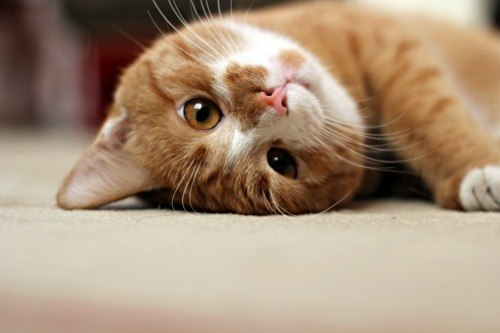